# Research Methodology (Week 7)

In [17]:
from scipy.io import loadmat
from collections import namedtuple
from math import floor
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import antropy as ant
import pywt
import os
import seaborn as sns
import warnings

# Experimental Algorithm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Gradient extreme gradient boosted trees
from xgboost import XGBRegressor

In [18]:
warnings.filterwarnings('ignore')
sns.set_theme()

<br/>

## The <code>create_dataset</code>  function

In [28]:
# Helper function to generate the dataset

def create_dataset(data_dir='training', patient=None): 
    """
    Generate training and test sets based on the 17 features selected from week 6. These 
    include all features with a correlation > 0.15 with the BIS.
    
    
    Parameters
    -----------
    data_dir : {"training", "test"}, default = 'training'
        Create the training or test dataset based on the selected features.
        
    patient : String, default=None
        Create the dataset of a patient. It depends on data_dir parameter i.e. if the
        data_dir is set to 'training', then the patient must be present in the training set,
        otherwise, the patient must be present in the test set.
        
        If None, the dataset of the patient is NOT created.
        
        
    Returns
    --------
    dataset: pd.DataFrame
        The training, test, or patient dataset.
    """
    
    folders = ["SampEntropy_CH2Squared", "Katz_CH2Squared", "SampEntropy", "Katz", "SampEntropy_CH2DenoisedSquared", "Katz_CH2DenoisedSquared", "PermEntropy_CH2DenoisedSquared", "Higuchi_CH2DenoisedSquared", "Petrosian_CH2Squared", "Petrosian", "Petrosian_CH2DenoisedSquared"]
    patient_dict = {}
    
    if data_dir == 'training':
        directory = 'Class A train sets'
        
    if data_dir == 'test':
        directory = 'Class B test sets'
        

    for folder in folders:
        if patient == None:
            # Creating the entire dataset using the data.csv files
            df = pd.read_csv("./{}/{}/Modified/data.csv".format(directory, folder))
            
        if patient != None:
            # Creating datasets for each patient
            try:
                df = pd.read_csv("./{}/{}/Modified/{}".format(directory, folder, patient+'_modified.csv'))
                
            except FileNotFoundError:
                print("Patient {} does not exist in the {} set.".format(patient, data_dir))
                return
                

        patient_dict['BIS'] = df['BIS']

        # CH2^2 Folder
        if folder == "Katz_CH2Squared":
            patient_dict['Katz_cA_4'] = df['Katz_cA_4']
            patient_dict['Katz_cD_2'] = df['Katz_cD_2']
            
        if folder == "SampEntropy_CH2Squared":
            patient_dict['SampenCA_4'] = df['SampenCA_4']
            patient_dict['SampenCD_2'] = df['SampenCD_2']


        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian_CH2Squared":
            patient_dict['Petrosian_CA_4'] = df["Petrosian_CA_4"]
            patient_dict['Petrosian_CD_3'] = df["Petrosian_CD_3"]
            
        

        # CH2Denoised Folders
        if folder ==  "SampEntropy":
            patient_dict['SampenCD_2D'] = df['SampenCD_2']
            patient_dict['SampenCA_4D'] = df['SampenCA_4']

        if folder ==  "Katz":
            patient_dict['Katz_cD_2D'] = df['Katz_cD_2']
            patient_dict['Katz_cA_4D'] = df['Katz_cA_4']

        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian":
            patient_dict["Petrosian_CA_4D"] = df["Petrosian_CA_4"]
            patient_dict["Petrosian_CD_3D"] = df["Petrosian_CD_3"]
            patient_dict["Petrosian_CD_1D"] = df["Petrosian_CD_1"]



        # CH2DenoisedSquared Folders
        if folder == "SampEntropy_CH2DenoisedSquared":
            patient_dict['SampenCA_4DS'] = df['SampenCA_4']
            patient_dict['SampenCD_2DS'] = df['SampenCD_2']


        if folder == "Katz_CH2DenoisedSquared":
            patient_dict['Katz_DeltaDS'] = df['Katz_Delta']
            patient_dict['Katz_cD_1DS'] = df['Katz_cD_1']
            patient_dict['Katz_cA_4DS'] = df['Katz_cA_4']
            


        if folder == "PermEntropy_CH2DenoisedSquared":
            patient_dict['Permen_cD_1DS'] = df['Permen_cD_1']
            patient_dict['Permen_cD_3DS'] = df['Permen_cD_3']
            patient_dict['Permen_GammaDS'] = df['Permen_Gamma']


        if folder == "Higuchi_CH2DenoisedSquared":
            patient_dict['Hig_cA_4DS'] = df['Hig_cA_4']


        # New method: Petrosian Fractal Dimension
        if folder == "Petrosian_CH2DenoisedSquared":
            patient_dict["Petrosian_CA_4DS"] = df["Petrosian_CA_4"]
            patient_dict["Petrosian_CD_3DS"] = df["Petrosian_CD_3"]
            patient_dict["Petrosian_CD_1DS"] = df["Petrosian_CD_1"]
            
            
    dataset = pd.DataFrame(patient_dict)
    
    return dataset

In [29]:
# TESTING:
# Generate the dataset for a patient
test_patient = create_dataset(patient="13_EEG20100609.mat")

In [30]:
test_patient.head()

,BIS,SampenCA_4,SampenCD_2,Katz_cA_4,Katz_cD_2,SampenCD_2D,SampenCA_4D,Katz_cD_2D,Katz_cA_4D,SampenCA_4DS,...,Permen_GammaDS,Hig_cA_4DS,Petrosian_CA_4,Petrosian_CD_3,Petrosian_CA_4D,Petrosian_CD_3D,Petrosian_CD_1D,Petrosian_CA_4DS,Petrosian_CD_3DS,Petrosian_CD_1DS
0,59.2,0.547261,0.781755,1.784283,3.430801,0.133905,0.348438,1.898219,2.593355,0.319543,...,0.941907,1.858706,1.020406,1.037599,1.016333,1.038507,1.027382,1.025735,1.037042,1.027435
1,59.0,0.549722,0.809499,1.727093,3.228548,0.135432,0.368834,1.900659,2.575024,0.317834,...,0.942772,1.859619,1.020161,1.037548,1.016084,1.038507,1.027542,1.025375,1.036991,1.027563
2,37.3,0.540384,0.874470,1.876292,3.305426,0.126914,0.405924,1.975516,2.594453,0.333829,...,0.945853,1.861839,1.019916,1.037447,1.016458,1.038557,1.027798,1.025615,1.036940,1.027819
3,37.3,0.549708,0.892080,1.851609,3.275842,0.132459,0.454419,1.996951,2.587282,0.353303,...,0.953219,1.865707,1.019916,1.037295,1.016333,1.038557,1.028032,1.025855,1.036839,1.028075
4,37.3,0.527510,0.919120,1.785929,3.380371,0.140863,0.506331,2.010299,2.607390,0.358351,...,0.951334,1.863204,1.020038,1.037295,1.016458,1.038457,1.028255,1.025375,1.036788,1.028393


In [31]:
# Generate the entire EEG training set
training_set = create_dataset()

In [32]:
training_set.head()

,BIS,SampenCA_4,SampenCD_2,Katz_cA_4,Katz_cD_2,SampenCD_2D,SampenCA_4D,Katz_cD_2D,Katz_cA_4D,SampenCA_4DS,...,Permen_GammaDS,Hig_cA_4DS,Petrosian_CA_4,Petrosian_CD_3,Petrosian_CA_4D,Petrosian_CD_3D,Petrosian_CD_1D,Petrosian_CA_4DS,Petrosian_CD_3DS,Petrosian_CD_1DS
0,95.8,1.118584,1.589795,2.579210,3.842405,0.295259,0.376660,2.220077,2.975620,0.308904,...,0.993749,1.812455,1.027288,1.035669,1.021992,1.036636,1.030315,1.029542,1.036382,1.030116
1,95.8,1.108791,1.578562,2.427762,3.855503,0.317506,0.404385,2.231705,2.945514,0.319252,...,0.993224,1.812594,1.027169,1.035873,1.022235,1.036839,1.030577,1.029542,1.036585,1.030378
2,95.8,1.111692,1.567324,2.581948,3.533784,0.342623,0.442947,2.239327,2.975240,0.328542,...,0.992231,1.810743,1.026573,1.035720,1.022600,1.036940,1.030892,1.029660,1.036636,1.030672
3,95.6,1.122940,1.594337,2.260806,3.837354,0.371085,0.492027,2.246107,2.976338,0.340638,...,0.991169,1.810351,1.026812,1.035516,1.022357,1.037042,1.031184,1.030014,1.036534,1.030954
4,95.6,1.091586,1.622987,2.301977,3.401760,0.403649,0.552274,2.251073,2.993204,0.337477,...,0.990647,1.808214,1.027050,1.035873,1.022478,1.037143,1.031529,1.030014,1.036788,1.031289


In [33]:
training_set.shape

(30141, 26)

In [34]:
# Save the training set
training_set.to_csv("training_set.csv", index=False)

<br/>

In [35]:
# Generate the entire EEG test set
test_set = create_dataset(data_dir='test')

In [36]:
test_set.head()

,BIS,SampenCA_4,SampenCD_2,Katz_cA_4,Katz_cD_2,SampenCD_2D,SampenCA_4D,Katz_cD_2D,Katz_cA_4D,SampenCA_4DS,...,Permen_GammaDS,Hig_cA_4DS,Petrosian_CA_4,Petrosian_CD_3,Petrosian_CA_4D,Petrosian_CD_3D,Petrosian_CD_1D,Petrosian_CA_4DS,Petrosian_CD_3DS,Petrosian_CD_1DS
0,97.7,0.801420,1.418848,2.328133,2.463534,0.368547,0.233077,2.078915,2.919703,0.229470,...,0.836531,1.798798,1.025255,1.036433,1.020895,1.037902,1.031164,1.029187,1.036128,1.030231
1,97.7,0.784840,1.422963,2.274184,2.452795,0.389602,0.257714,2.086262,2.987702,0.242878,...,0.833718,1.805899,1.025135,1.036331,1.020773,1.037801,1.031425,1.029187,1.036077,1.030546
2,97.7,0.807091,1.413197,2.305547,2.445056,0.417323,0.287493,2.099790,3.001366,0.259536,...,0.828082,1.792913,1.025135,1.036382,1.020773,1.037952,1.031716,1.029187,1.036331,1.030829
3,97.7,0.781947,1.419676,2.288078,2.443290,0.448100,0.323537,2.105070,3.038457,0.273634,...,0.842712,1.786796,1.025375,1.036026,1.021017,1.037851,1.031935,1.029424,1.036331,1.031059
4,97.7,0.785484,1.421532,2.099789,2.445678,0.458389,0.365158,2.147259,3.062842,0.294886,...,0.923256,1.794556,1.024774,1.036178,1.021017,1.037851,1.032070,1.029187,1.036331,1.031237


In [37]:
test_set.shape

(36859, 26)

In [38]:
# Save the test set
test_set.to_csv("test_set.csv", index=False)

<br/>

<br/>

# Checking the proportions of anaesthetic states

In [27]:
def proportions(df, generate=None, size=1000,):
    
    awake = df[(df.BIS >= 80) & (df.BIS < 100)]
    light = df[(df.BIS >= 60) & (df.BIS < 80)]
    moderate = df[(df.BIS >= 40) & (df.BIS < 60)]
    deep = df[df.BIS < 40]
    
  
    if generate == "awake":
        awake_idx = get_random(list(awake.index), size)
        gen_awake = df.loc[awake_idx]
        print("Generated {} awake samples".format(gen_awake.shape[0]))

        # remove rows from the dataframe
        df_new = df.drop(awake_idx, axis=0)

        return gen_awake, df_new
    
    
    if generate == "light":
        light_idx = get_random(list(light.index), size)
        gen_light = df.loc[light_idx]
        print("Generated {} light samples".format(gen_light.shape[0]))

        # remove rows from the dataframe
        df_new = df.drop(light_idx, axis=0)

        return gen_light, df_new


    
    if generate == 'moderate':
        moderate_idx = get_random(list(moderate.index), size)
        gen_mod = df.loc[moderate_idx]
        print("Generated {} moderate samples".format(gen_mod.shape[0]))

        # remove rows from the dataframe
        df_new = df.drop(moderate_idx, axis=0)

        return gen_mod, df_new

    
    
    if generate == 'deep':
        deep_idx = get_random(list(deep.index), size)
        gen_deep = df.loc[deep_idx]
        print("Generated {} deep samples".format(gen_deep.shape[0]))

        # remove rows from the dataframe
        df_new = df.drop(deep_idx, axis=0)

        return gen_deep, df_new
    
    

    if generate == None:
        # Just proportions
        print("Proportions")
        print("-----------")
        print("Awake: {}".format(awake.shape[0]))
        print("Light: {}".format(light.shape[0]))
        print("Moderate: {}".format(moderate.shape[0]))
        print("Deep: {}".format(deep.shape[0]))
    

In [28]:
def get_random(list_, size):
    for _ in range(1000):
        np.random.shuffle(list_)

    return np.random.choice(list_, size, replace=False)

In [29]:
proportions(training_set) # Training set

Proportions
-----------
Awake: 1892
Light: 3918
Moderate: 10079
Deep: 14252


In [30]:
proportions(test_set) # Test set

Proportions
-----------
Awake: 1619
Light: 1298
Moderate: 13725
Deep: 20217


<blockquote><b>There are more test samples than training samples.</b> So I moved some things around.</blockquote>

In [31]:
# Moving things around with the proportions function

In [33]:
# TESTING:
# Remove excess awake samples from the test set
awake, new_df = proportions(test_set, generate='awake', size=500) # Use the test set!

# Remove excess moderate anaesthesia samples from the test set
moderate, new_df = proportions(new_df, generate="moderate", size=3550)

# Remmove excess deep anaesthesia samples from the test set
deep, new_df = proportions(new_df, generate='deep', size=6725)

print()

# Checkout the new proportions
proportions(new_df)

Generated 500 awake samples
Generated 3550 moderate samples
Generated 6725 deep samples

Proportions
-----------
Awake: 1119
Light: 1298
Moderate: 10175
Deep: 13492


In [34]:
new_df.shape # New test set

(26084, 18)

In [36]:
test_add = pd.concat([training_set, awake, moderate, deep]) # New training set

proportions(test_add)

Proportions
-----------
Awake: 2392
Light: 3918
Moderate: 13629
Deep: 20977


In [37]:
test_add.shape # Now there's more samples in the training set.

(40916, 18)

In [38]:
# We can now build a better model (perhaps) in the next section.
# Save the training and test sets
new_df.to_csv("test_set.csv", index=False)
test_add.to_csv("training_set.csv", index=False)

<br/>

<br/>

<br/>

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem;">
    <h1 style="margin: 0; color: #343d52">Model Building</h1>
</div>

## Selection of Relevant features

In [39]:
eeg_df = pd.read_csv("training_set.csv")
eeg_df.head()

,BIS,SampenCA_4,SampenCD_2,Katz_cA_4,Katz_cD_2,SampenCD_2D,SampenCA_4D,Katz_cD_2D,Katz_cA_4D,SampenCA_4DS,...,Permen_GammaDS,Hig_cA_4DS,Petrosian_CA_4,Petrosian_CD_3,Petrosian_CA_4D,Petrosian_CD_3D,Petrosian_CD_1D,Petrosian_CA_4DS,Petrosian_CD_3DS,Petrosian_CD_1DS
0,95.8,1.118584,1.589795,2.579210,3.842405,0.295259,0.376660,2.220077,2.975620,0.308904,...,0.993749,1.812455,1.027288,1.035669,1.021992,1.036636,1.030315,1.029542,1.036382,1.030116
1,95.8,1.108791,1.578562,2.427762,3.855503,0.317506,0.404385,2.231705,2.945514,0.319252,...,0.993224,1.812594,1.027169,1.035873,1.022235,1.036839,1.030577,1.029542,1.036585,1.030378
2,95.8,1.111692,1.567324,2.581948,3.533784,0.342623,0.442947,2.239327,2.975240,0.328542,...,0.992231,1.810743,1.026573,1.035720,1.022600,1.036940,1.030892,1.029660,1.036636,1.030672
3,95.6,1.122940,1.594337,2.260806,3.837354,0.371085,0.492027,2.246107,2.976338,0.340638,...,0.991169,1.810351,1.026812,1.035516,1.022357,1.037042,1.031184,1.030014,1.036534,1.030954
4,95.6,1.091586,1.622987,2.301977,3.401760,0.403649,0.552274,2.251073,2.993204,0.337477,...,0.990647,1.808214,1.027050,1.035873,1.022478,1.037143,1.031529,1.030014,1.036788,1.031289


<br/>

## Feature Selection and Multicollinearity

In [42]:
def correlation_matrix(df):    
    figure = plt.figure(figsize=(30, 30))
    cm = np.corrcoef(df[df.columns].values.T)
    sns.set(font_scale=1.5)

    # Heatmap
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={'size' : 20}, yticklabels=df.columns, xticklabels=df.columns)

    plt.show()

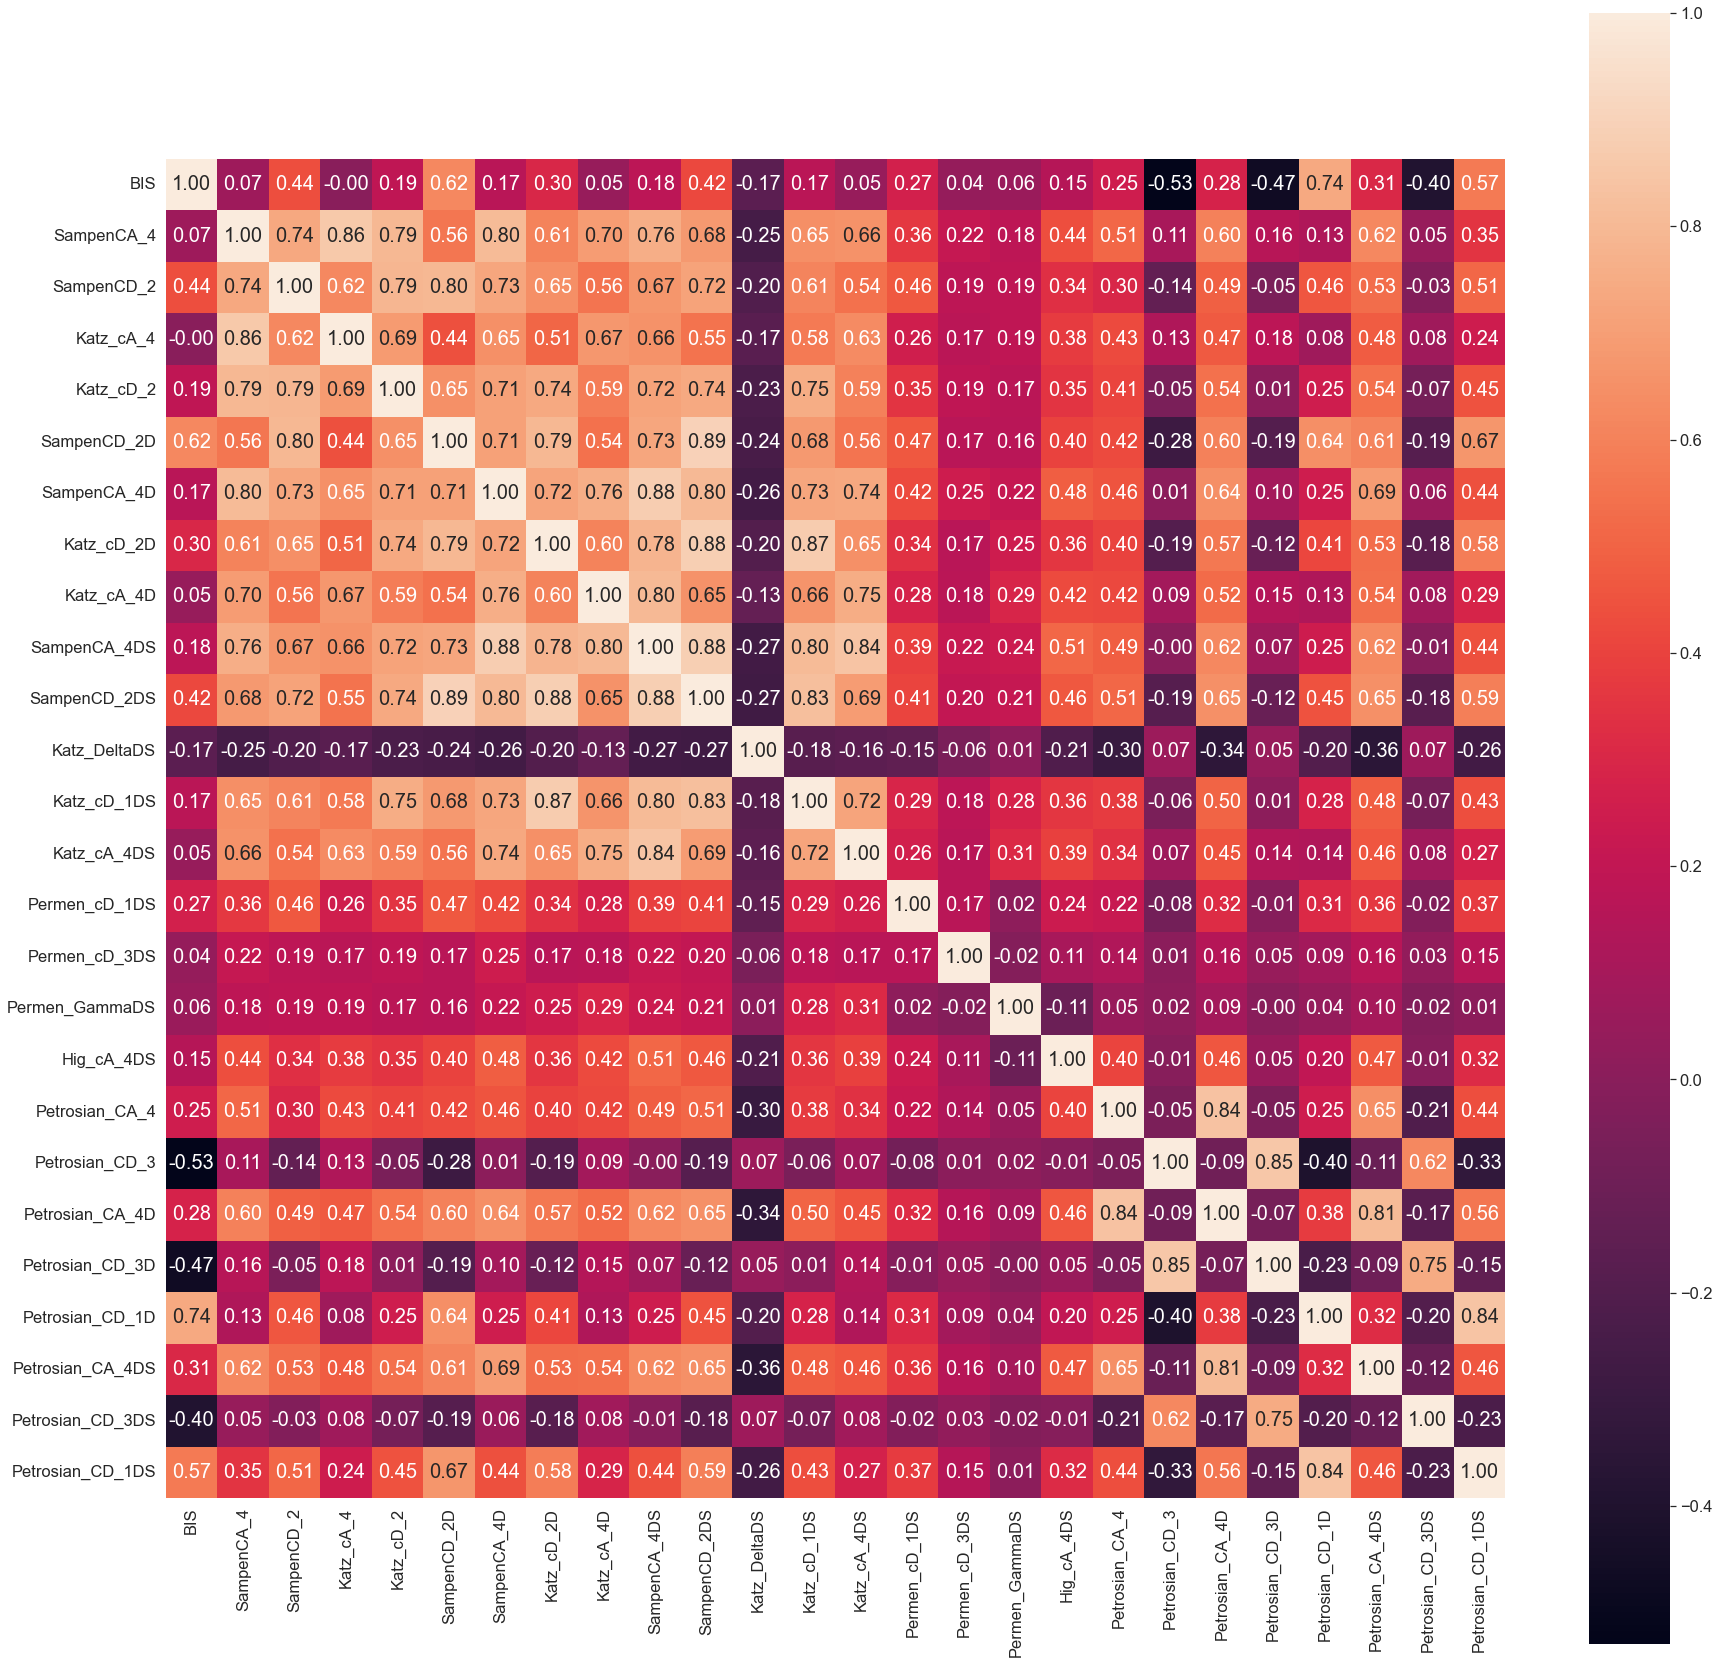

In [43]:
# Selected features: INITIAL
cols = ['Katz_cA_4', 'SampenCD_2', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_DeltaDS', 'Katz_cD_1DS', 'Permen_cD_1DS', 'Hig_cA_4DS']

# Checking for multicollinearity
correlation_matrix(eeg_df[eeg_df.columns])

In [52]:
# Selected Features: INCLUDING PETROSIAN FEATURES
cols = [
    'Katz_cA_4', 'SampenCD_2', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D',
    'SampenCA_4DS', 'SampenCD_2DS', 'Katz_DeltaDS', 'Katz_cD_1DS', 
    'Permen_cD_1DS', 'Hig_cA_4DS', "Petrosian_CA_4", "Petrosian_CD_3", 
    'Petrosian_CA_4D', "Petrosian_CD_3D", "Petrosian_CD_1D", "Petrosian_CA_4DS",
    "Petrosian_CD_3DS", "Petrosian_CD_1DS"
]


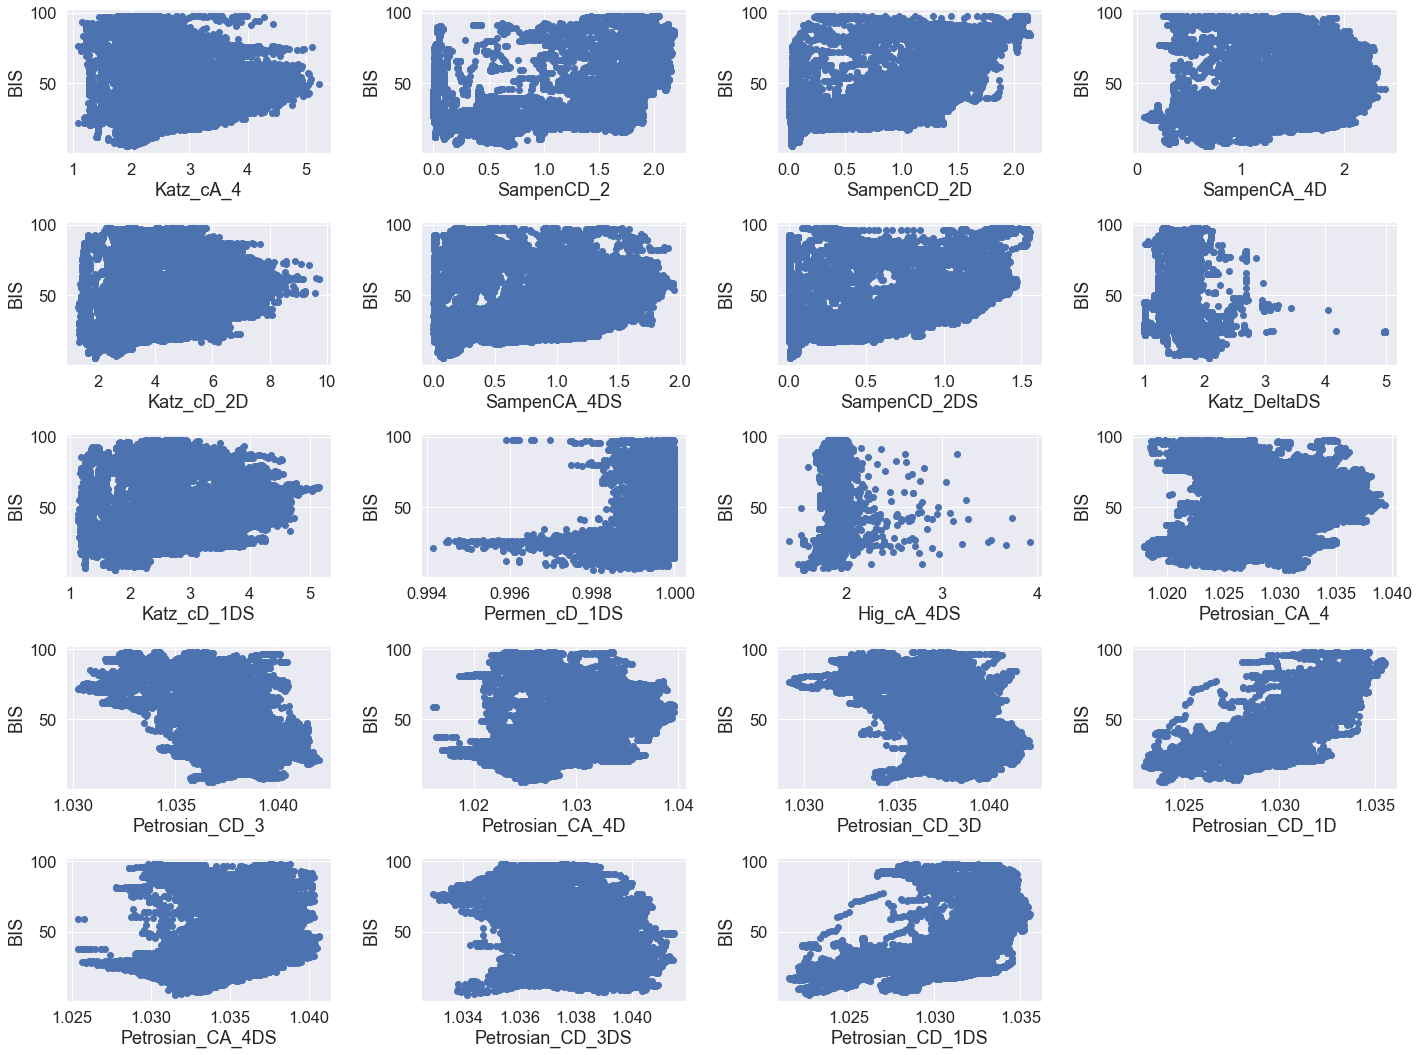

In [51]:
# Check the relationship between the selected features and the BIS
fig, ax = plt.subplots(5, 4, figsize=(20, 15))

ax[4, 3].axis('off')

for idx, feature in enumerate(cols[:4]):
    ax[0, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[0, idx].set_ylabel('BIS')
    ax[0, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[4:8]):
    ax[1, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[1, idx].set_ylabel('BIS')
    ax[1, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[8:12]):
    ax[2, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[2, idx].set_ylabel('BIS')
    ax[2, idx].set_xlabel(feature)

for idx, feature in enumerate(cols[12:16]):
    ax[3, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[3, idx].set_ylabel('BIS')
    ax[3, idx].set_xlabel(feature)


for idx, feature in enumerate(cols[16:20]):
    ax[4, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[4, idx].set_ylabel('BIS')
    ax[4, idx].set_xlabel(feature)


    
plt.tight_layout()
plt.show()

<br/>

## Model Building with Selected Features

In [53]:
selected_features = ['Katz_cA_4', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_DeltaDS', 'Katz_cD_1DS', 'Permen_cD_1DS', 'Hig_cA_4DS', "Petrosian_CA_4", "Petrosian_CD_3", 
    'Petrosian_CA_4D', "Petrosian_CD_3D", "Petrosian_CD_1D", "Petrosian_CA_4DS", "Petrosian_CD_3DS", "Petrosian_CD_1DS"]

len(selected_features)

18

In [33]:
training_data = []

In [14]:
class model:
    
    my_model = None

    def __init__(self, model, data, scale):
        self.model = model
        self.data = data
        self.scale = scale
        
        
    def fit(self, features):
        X = self.data[features]
        y = self.data['BIS']
        
        if self.scale == True:
            scaled_X = StandardScaler()
            scaled_Y = StandardScaler()

            X = scaled_X.fit_transform(X)
            y = scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
        
        # Linear regression
        if self.model == 'lr':
            my_model = LinearRegression()
            my_model.fit(X, y)
                
            self.my_model = my_model
            print("Done training")
            
            
        # Decision tree
        if self.model == "tree":
            max_depth = 10
            my_model = DecisionTreeRegressor(max_depth=max_depth)
            my_model.fit(X, y)
            
            self.my_model = my_model
            print("Done training")
            
            
        # RandomForestRegressor
        if self.model == "forest":
            my_model = RandomForestRegressor(n_estimators=1000, criterion='mse',
                                            random_state=-1, n_jobs=-1)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
        # Support Vector Regression
        if self.model == 'svr':
            my_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
        # Linear Support Vector regression
        if self.model == "lsvr":
            my_model = SVR(kernel='linear', C=1.0, epsilon=0.2)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
        # Ridge regression 
        if self.model == 'rr':
            my_model = Ridge(alpha=1.0)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
        # Histogram-based Gradient boosting regression tree (Experimental)
        if self.model == 'hist_r':
            my_model = HistGradientBoostingRegressor(max_depth=10)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
        if self.model == "xgboost":
            my_model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
            
            
            
            
            
            
            
    def predict(self, test_data, features, visualize=True, evaluate=True):
        
        if self.my_model == None:
            raise Exception("Call the fit() method to train a model")
            
        X = test_data[features]
        y = test_data['BIS']
        xmin, xmax = 0, 110
        
        if self.scale == True:
            test_scaled_X = StandardScaler()
            test_scaled_Y = StandardScaler()
            
            X = test_scaled_X.fit_transform(X)
            y = test_scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            # For the residual plot
            xmin, xmax = -3, 3
            
            
        # Predict
        y_pred = self.my_model.predict(X)
            
        # Visualize after predicting    
        if visualize == True:
            figure = plt.figure(figsize=(15, 10))
            plt.plot(y, label="Actual BIS")
            plt.plot(y_pred, label="Predicted BIS")
            plt.xlabel('Samples')
            plt.ylabel('BIS')
            plt.legend(loc='upper left')
            plt.title("Depth of Anaesthesia assessment with EEG")
            plt.show()
            
            
        if evaluate == True:
            # Residual plot
            figure = plt.figure(figsize=(15, 10))
            plt.scatter(y_pred, y_pred - y, c='royalblue', marker='o',  edgecolor='white')
            plt.ylabel("Residuals")
            plt.xlabel("Predicted Values")
            plt.hlines(y=0, xmin=xmin, xmax=xmax, color='black', lw=2)
            plt.xlim([xmin, xmax])
            plt.show()
            
            
            # MSE and R^2
            mse = mean_squared_error(y, y_pred)
            
            print("MSE: %.3f" % mse)

                
                
        
            

In [35]:
# Testing a linear regression model
test_model = model('lr', eeg_df, scale=False)

test_model.fit(selected_features)

Done training


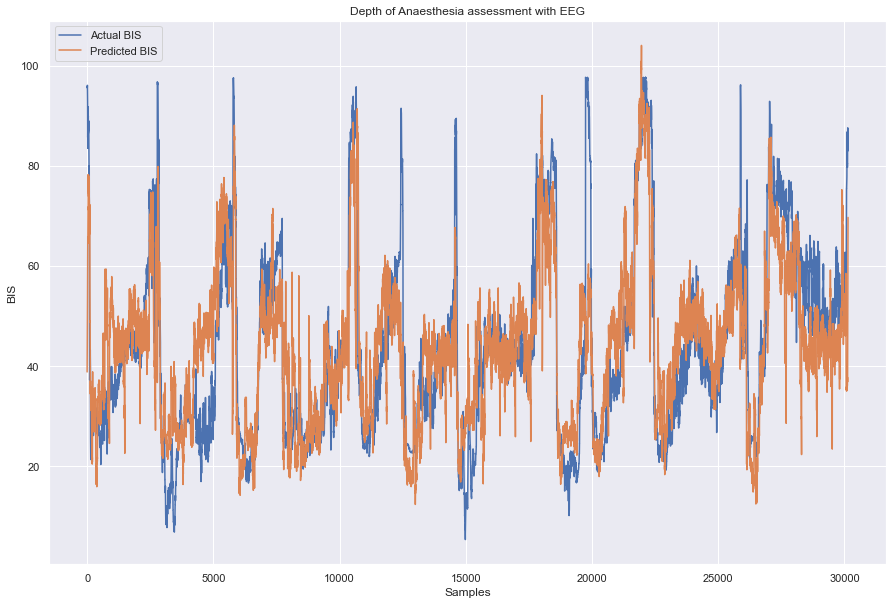

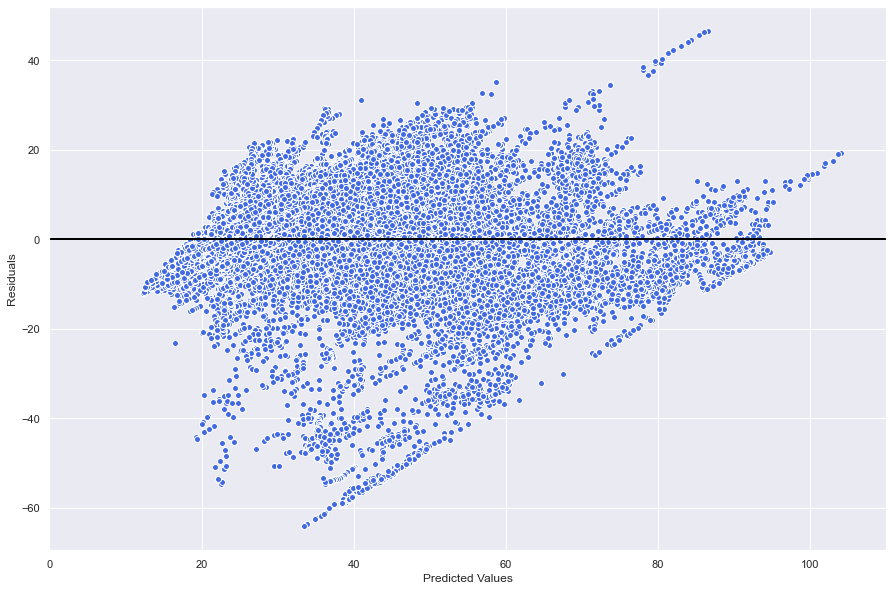

MSE: 144.060


In [36]:
test_model.predict(eeg_df, selected_features)

<br/>

<br/>

<br/>

## Patient files

In [38]:
# Training set (The patients)
training_set = [file for file in os.listdir("./Class A train sets") if ".mat" in file]

<br/>

## <code>LinearRegression</code>

In [39]:
# Create a linear regression model using the entire training dataset
lr = model('lr', eeg_df, scale=False)

# Train the model
lr.fit(selected_features)

Done training


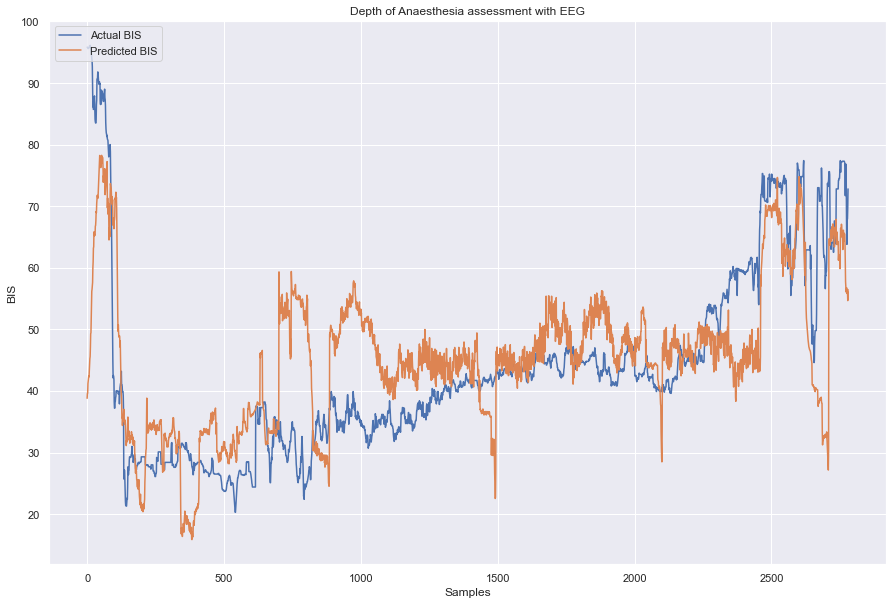

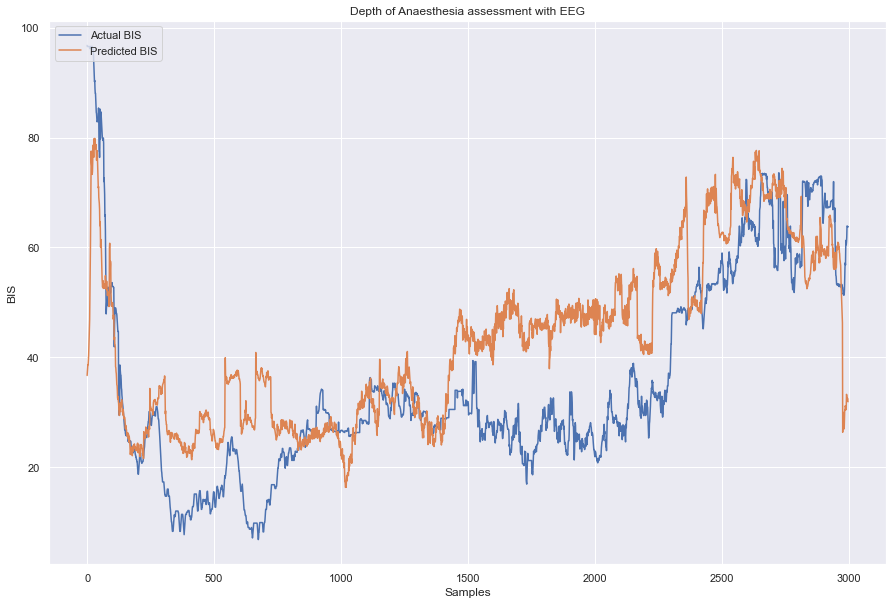

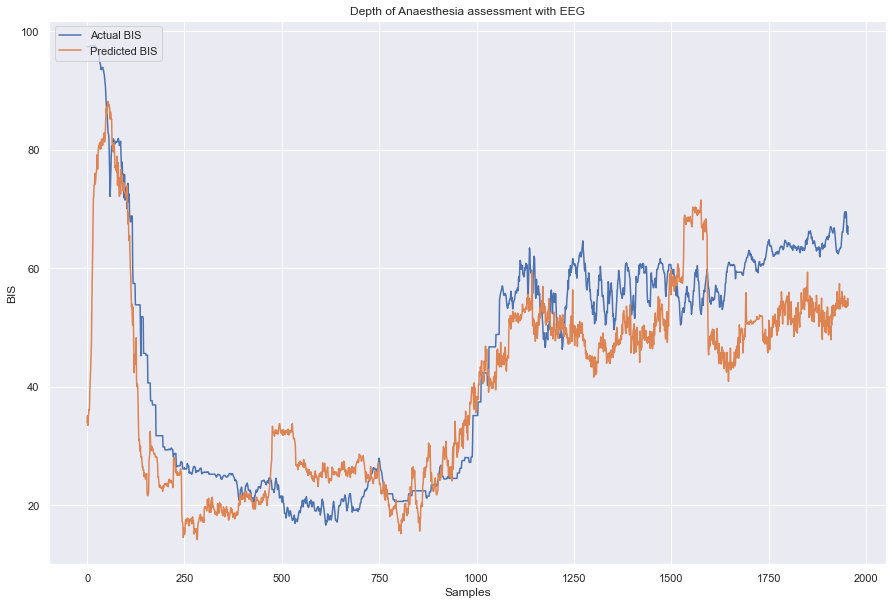

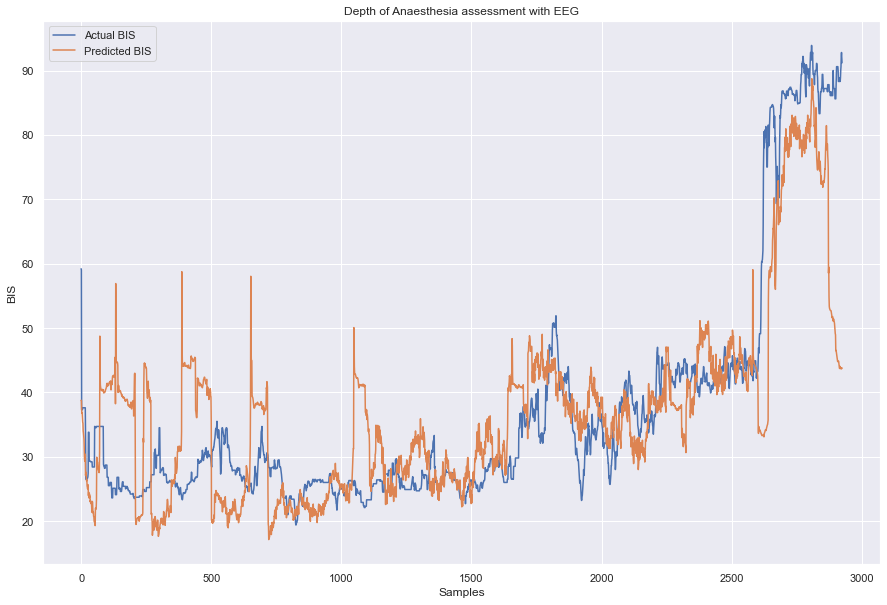

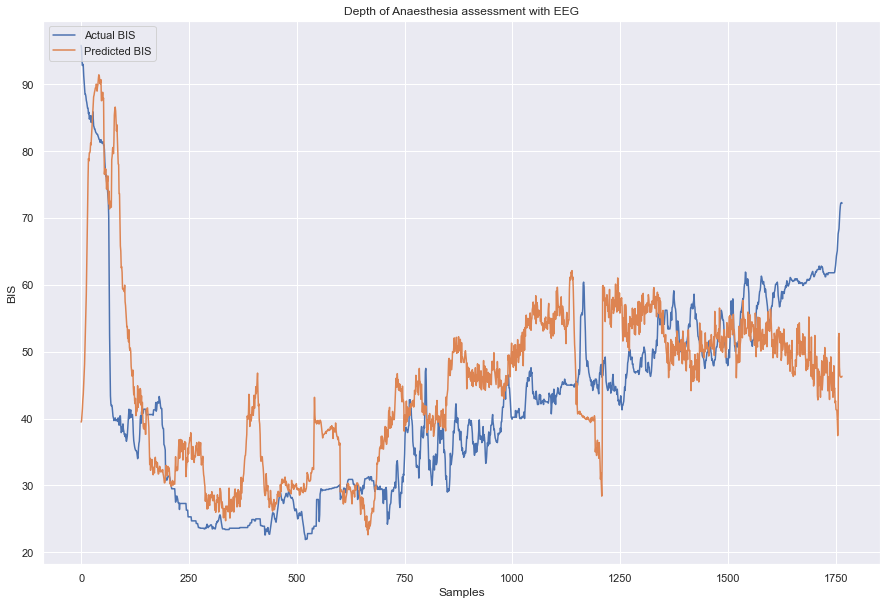

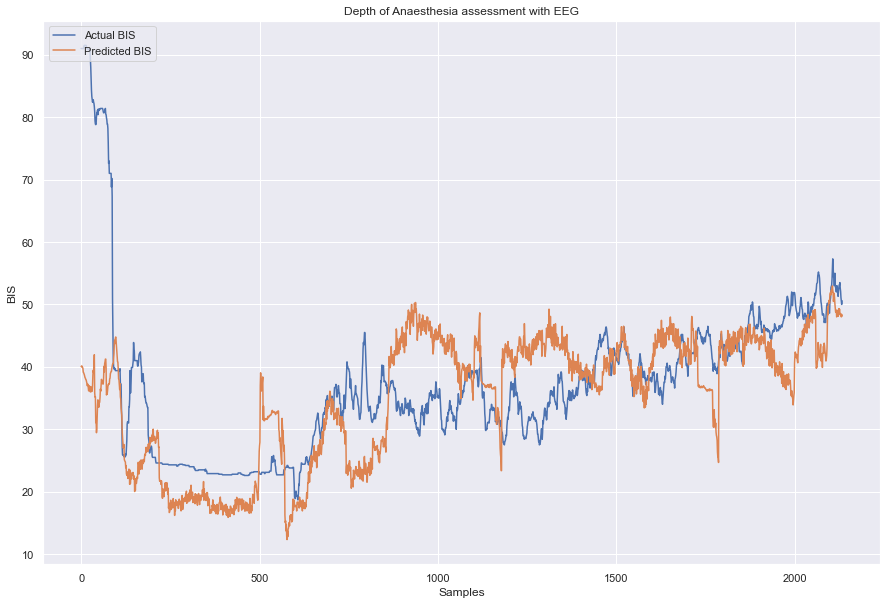

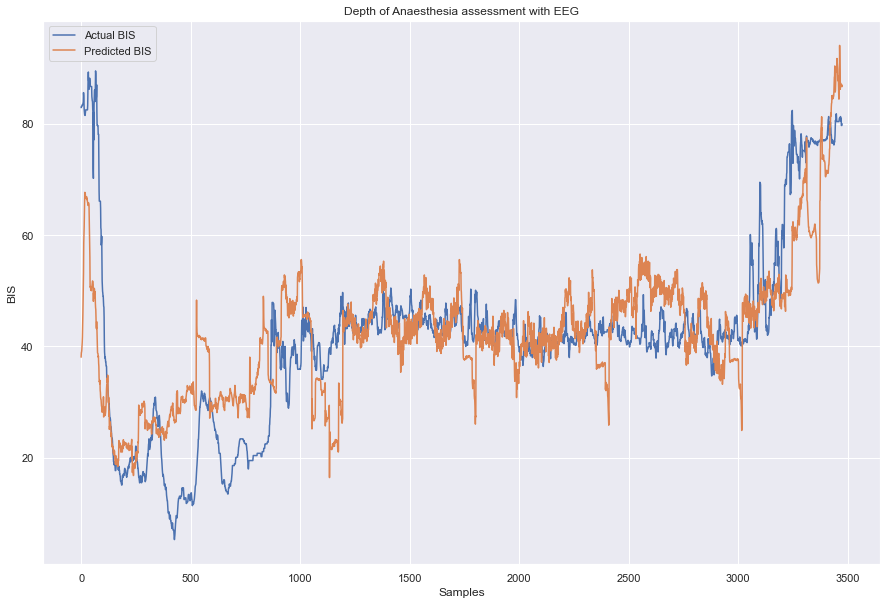

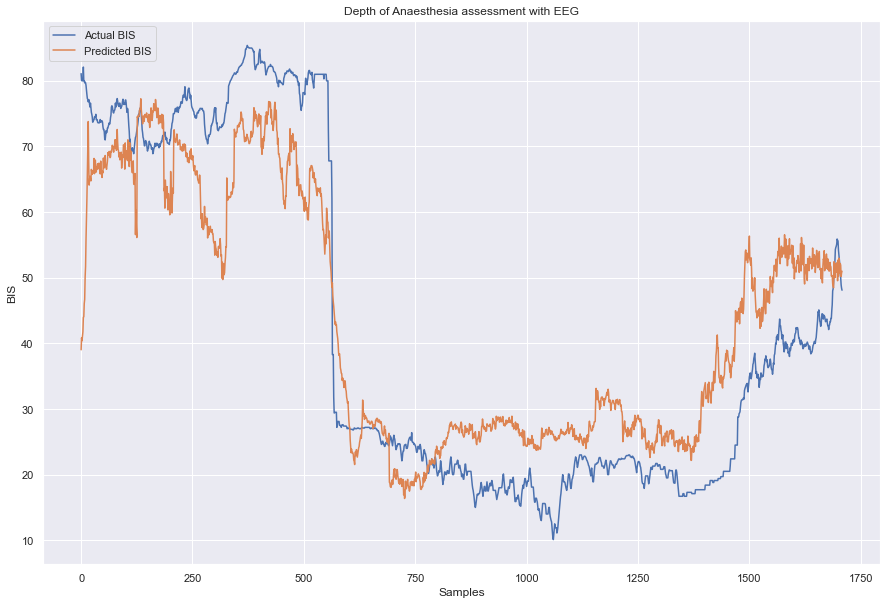

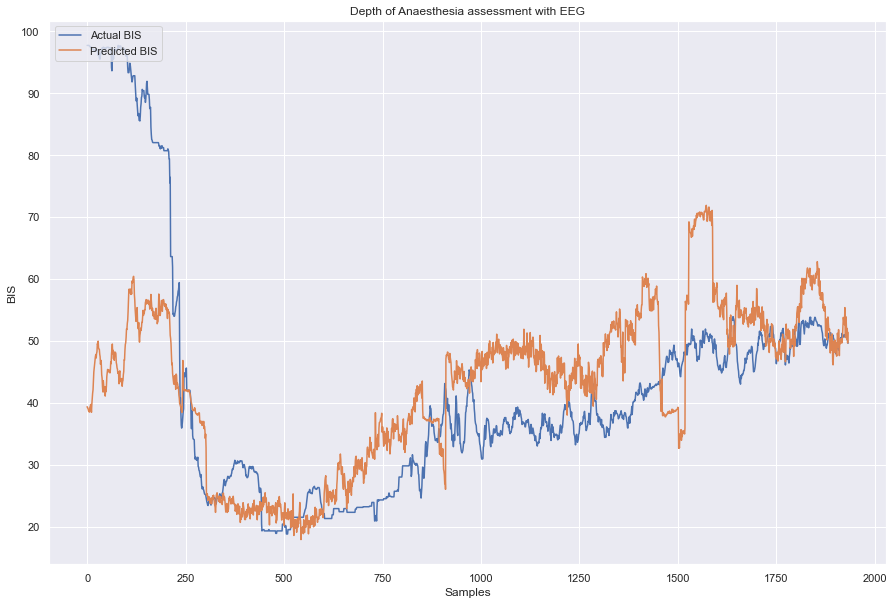

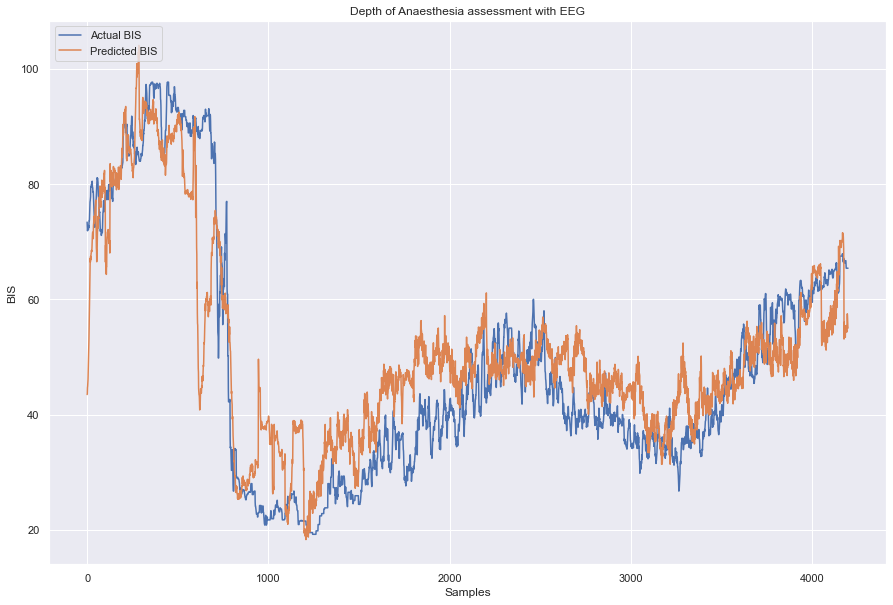

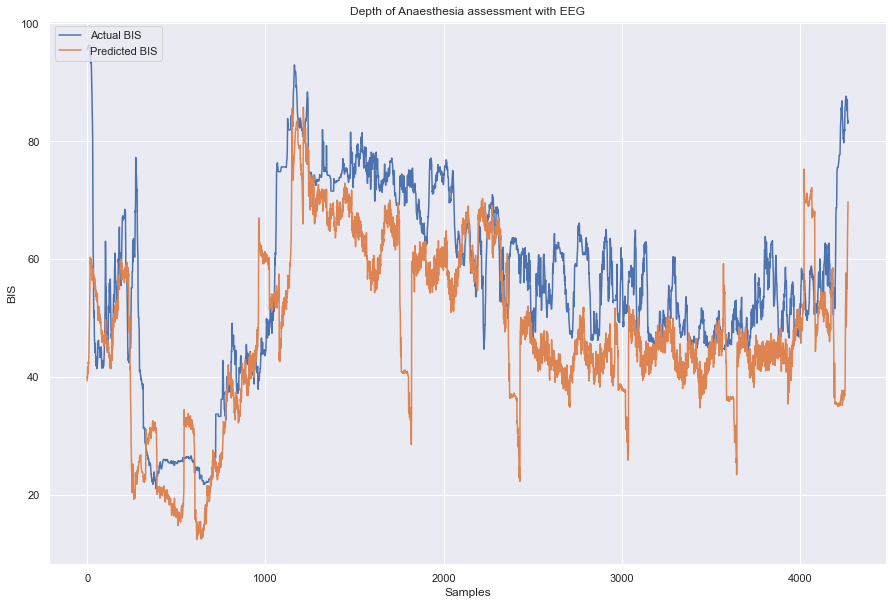

In [40]:
for train in training_set:
    patient = create_dataset(patient=train)
    lr.predict(patient, selected_features, evaluate=False)

<br/>

## <code>Decision Tree Regression</code>

In [42]:
# Create a linear regression model using the entire training dataset
tree = model('tree', eeg_df, scale=False)

# Train the model
tree.fit(selected_features)

Done training


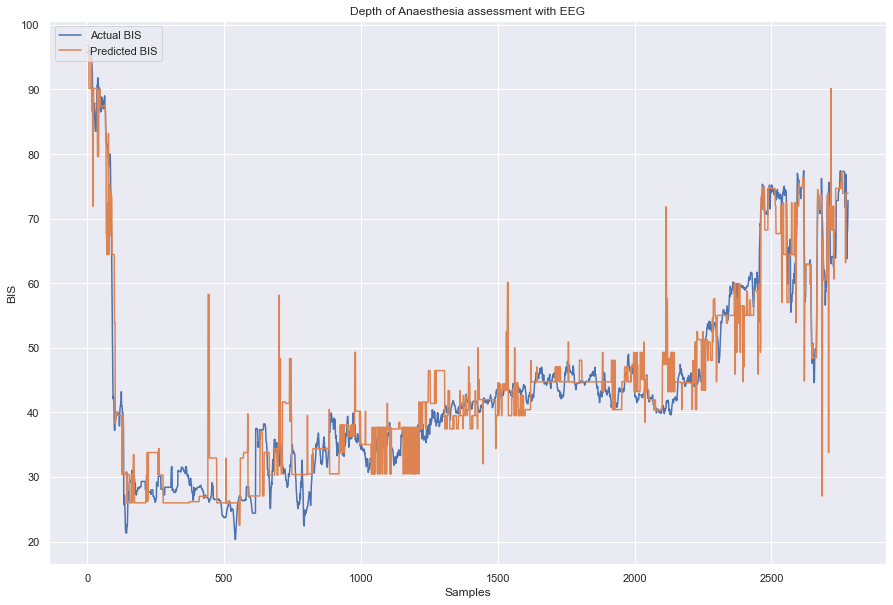

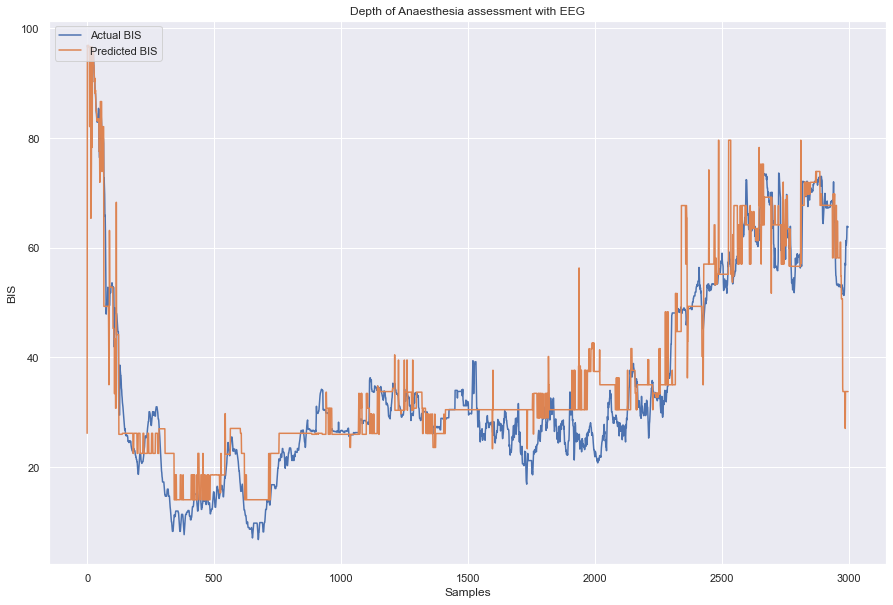

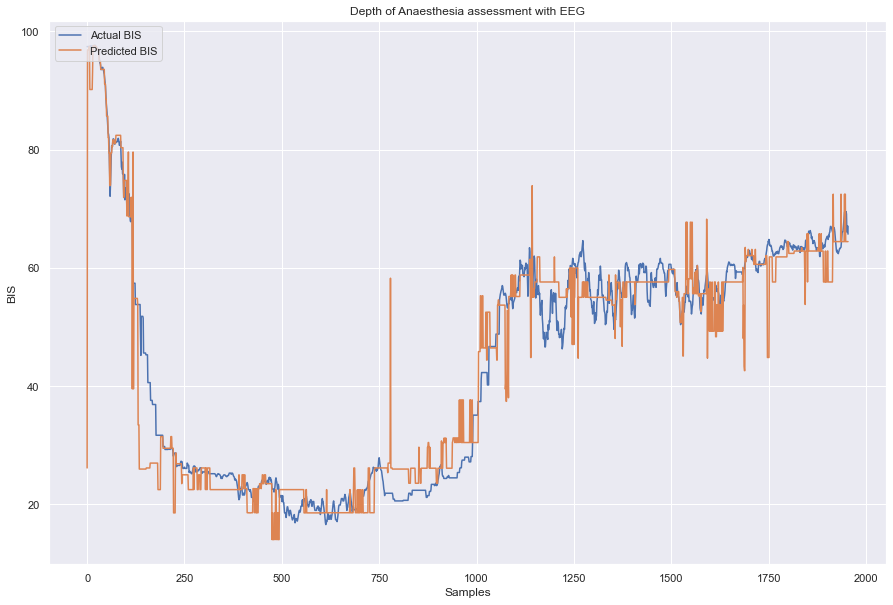

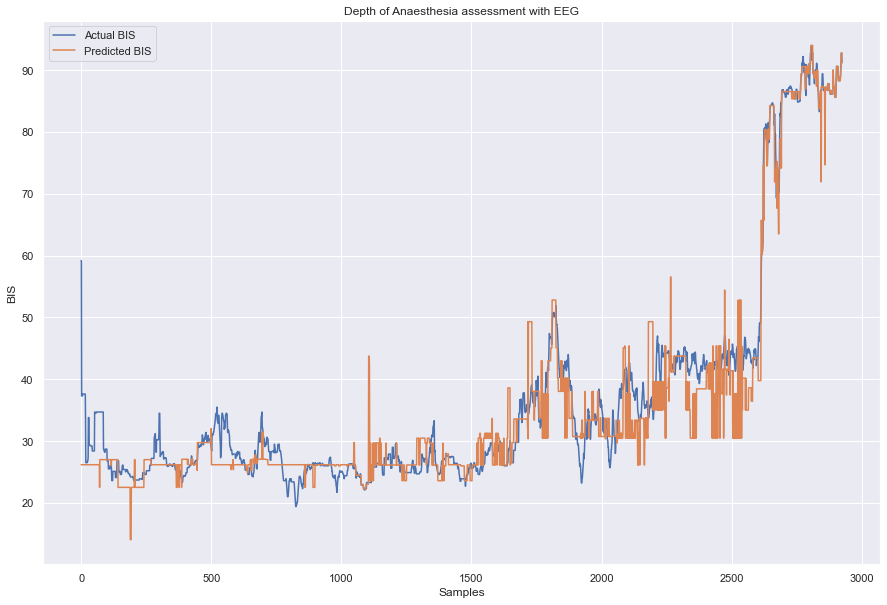

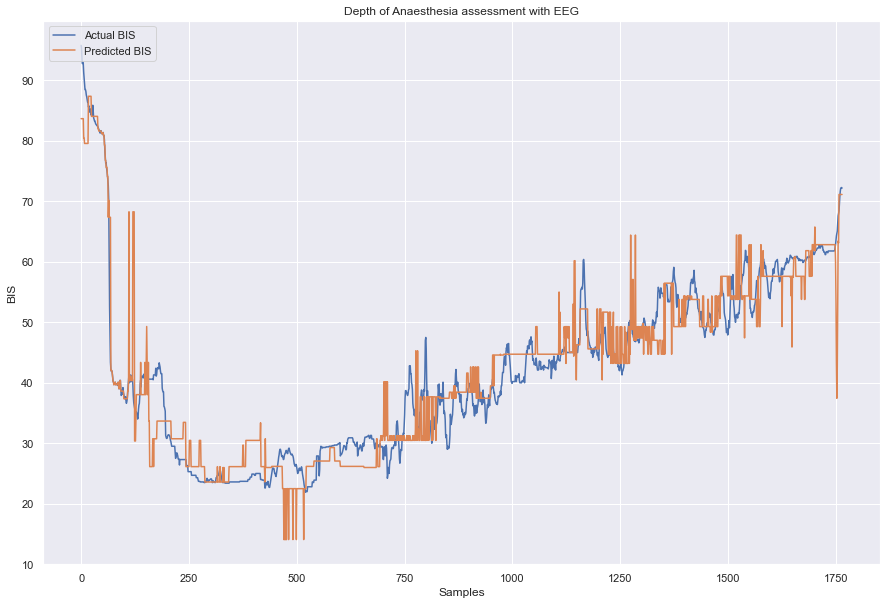

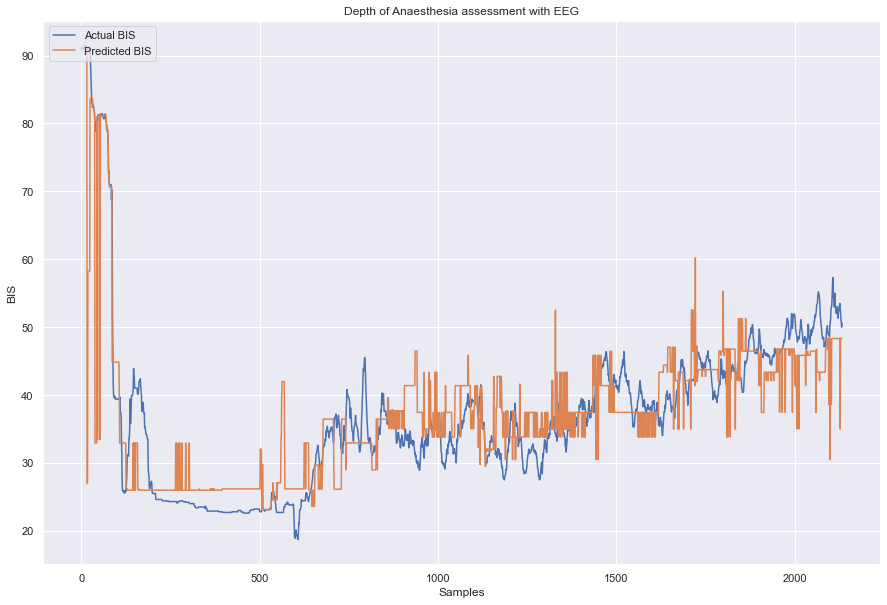

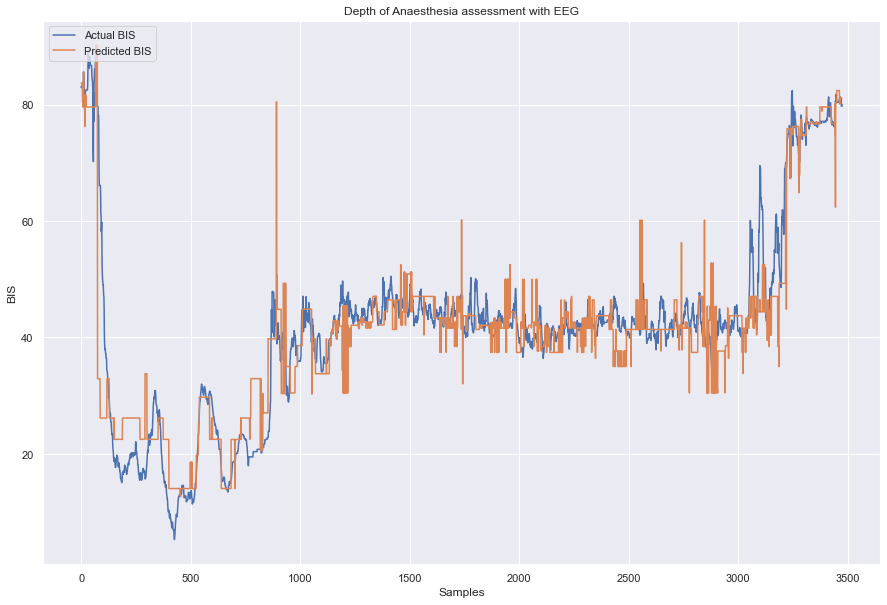

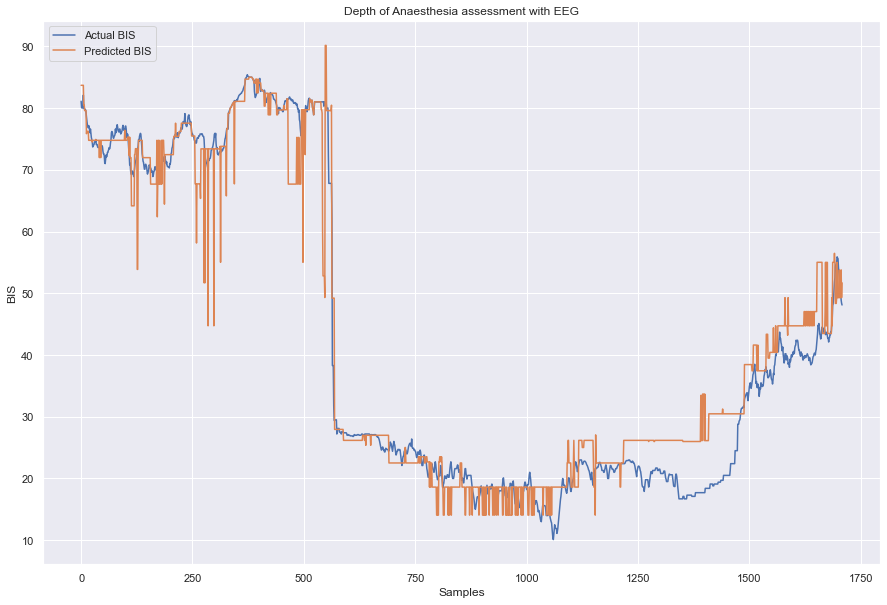

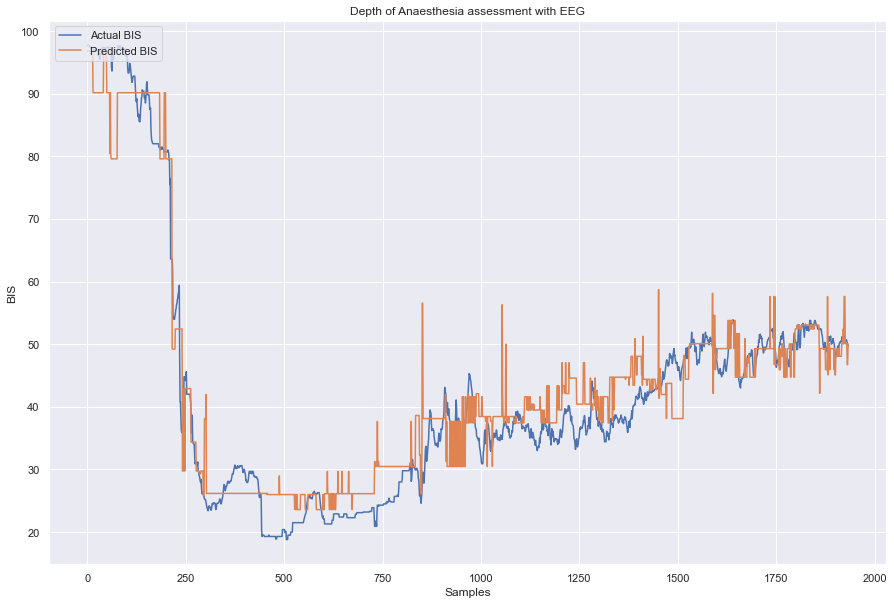

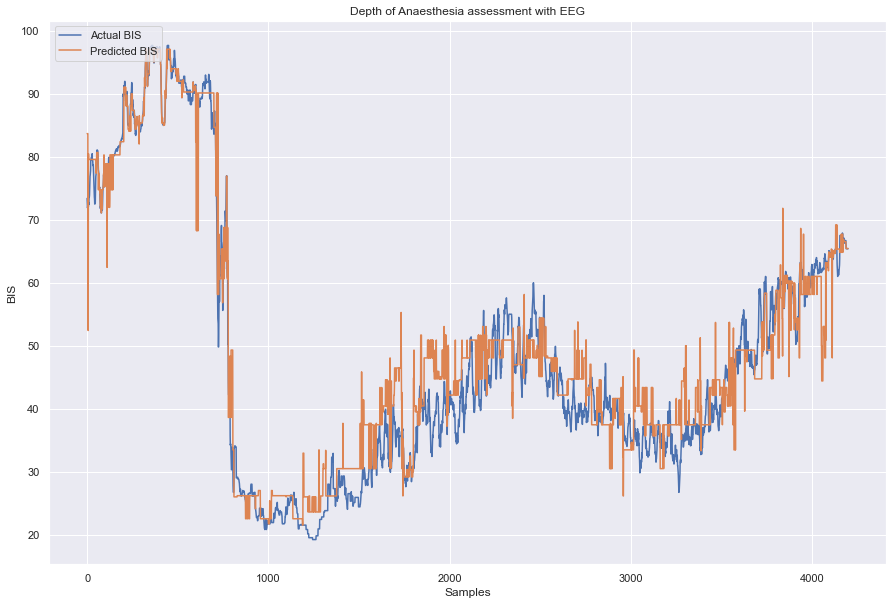

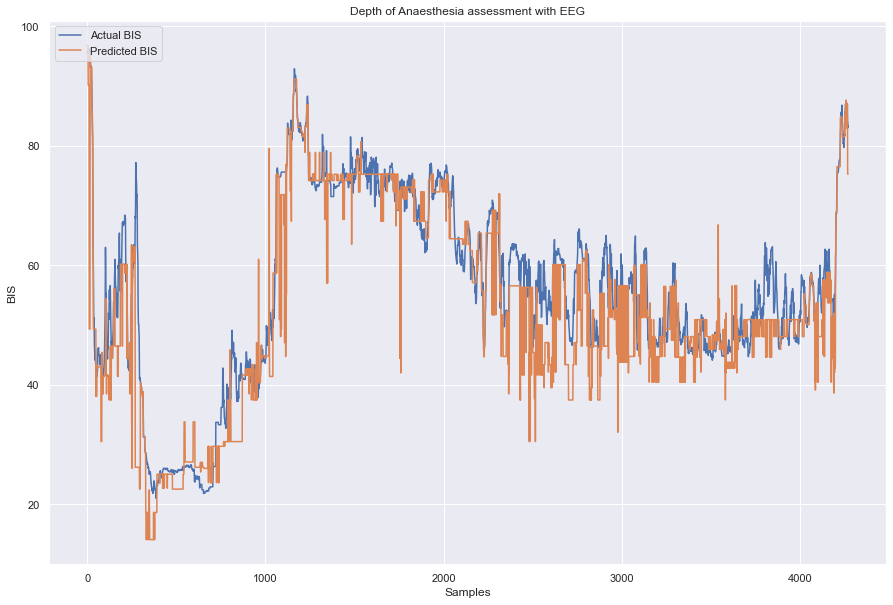

In [43]:
for train in training_set:
    patient = create_dataset(patient=train)
    tree.predict(patient, selected_features, evaluate=False)

<br/>